# Laboratory 5: Chronic kidney disease

In [69]:
import pandas as pd
import numpy as np
from sklearn import tree, ensemble
import matplotlib.pyplot as plt

ckd -> class kidney disease
importance -> proportional to distance from the root of the tree

In [70]:
# define the feature names:
feat_names = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc',
              'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo',
              'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe',
              'ane', 'classk']
feat_cat = np.array(['num', 'num', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat',
                     'num', 'num', 'num', 'num', 'num', 'num', 'num', 'num', 'num',
                     'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat'])

In [71]:
# xx=pd.read_csv("./Chronic_Kidney_Disease/chronic_kidney_disease.arff",sep=',',
#               skiprows=29,names=feat_names, 
#               header=None,na_values=['?','\t?'],
#               warn_bad_lines=True)
xx = pd.read_csv("./data/chronic_kidney_disease_v2.arff", sep=',',
                 skiprows=29, names=feat_names,
                 header=None, na_values=['?', '\t?'], )
Np, Nf = xx.shape

In [72]:
# change categorical data into numbers:
target_names = ['notckd', 'ckd']  # for the final plots
mapping = {
    'normal': 0,
    'abnormal': 1,
    'present': 1,
    'notpresent': 0,
    'yes': 1,
    ' yes': 1,
    'no': 0,
    '\tno': 0,
    '\tyes': 1,
    'ckd': 1,
    'notckd': 0,
    'poor': 1,
    'good': 0,
    'ckd\t': 1}
xx = xx.replace(mapping.keys(), mapping.values())

print('cardinality of each feature:')
print(
    xx.nunique())  # show the cardinality of each feature in the dataset; in particular classk should have only two possible values

cardinality of each feature:
age        76
bp         10
sg          5
al          6
su          6
rbc         2
pc          2
pcc         2
ba          2
bgr       146
bu        118
sc         84
sod        34
pot        40
hemo      115
pcv        42
wbcc       89
rbcc       45
htn         2
dm          2
cad         2
appet       2
pe          2
ane         2
classk      2
dtype: int64


In [73]:
miss_values = xx.isnull().sum(axis=1)  # Counts the number of missing values for each feature
for k in range(miss_values.max() + 1):  # Counts how many k missing values are present, for each k
    print(k, np.sum(miss_values == k))

0 158
1 45
2 33
3 37
4 31
5 33
6 12
7 20
8 8
9 12
10 4
11 7


In [74]:
# manage the missing data through regression
print(xx.info())
x = xx.copy()
# drop rows with less than 19=Nf-6 recorded features:
x = x.dropna(thresh=19)
x.reset_index(drop=True, inplace=True)  # necessary to have index without "jumps"
n = x.isnull().sum(axis=1)  # check the number of missing values in each row
print('Number of points in the original dataset: ', xx.shape[0])
print('reduced dataset: at least 19 values per row')
print('number of points in the reduced dataset: ', x.shape[0])
print('max number of missing values in the reduced dataset: ', n.max())
# take the rows with exctly Nf=25 useful features; this is going to be the training dataset
# for regression
Xtrain = x.dropna(thresh=25)
Xtrain.reset_index(drop=True, inplace=True)  # reset the index of the dataframe
print('Number of points in the training dataset: ', Xtrain.shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    float64
 6   pc      335 non-null    float64
 7   pcc     396 non-null    float64
 8   ba      396 non-null    float64
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wbcc    294 non-null    float64
 17  rbcc    269 non-null    float64
 18  htn     398 non-null    float64
 19  dm      398 non-null    float64
 20  cad     398 non-null    float64
 21  appet   399 non-null    float64
 22  pe

In [75]:
# normalize the training dataset
mm = Xtrain.mean(axis=0)
ss = Xtrain.std(axis=0)
Xtrain_norm = (Xtrain - mm) / ss

In [76]:
# normalize the entire dataset using the coeffs found for the training dataset
X_norm = (x - mm) / ss
Np, Nf = X_norm.shape

In [77]:
# run linear regression using least squares on all the missing data
X_norm_new = X_norm.copy()
for kk in range(Np):
    xrow = X_norm_new.iloc[kk]  # k-th row
    mask = xrow.isna()  # columns with nan in row k
    Data_tr_norm = Xtrain_norm.loc[:, ~mask]  # remove the columns from the training dataset
    y_tr_norm = Xtrain_norm.loc[:, mask]  # columns to be regressed
    w1 = np.linalg.inv(np.dot(Data_tr_norm.T, Data_tr_norm))
    h = np.dot(np.dot(w1, Data_tr_norm.T), y_tr_norm)  # weight vector
    ytest_norm = np.dot(X_norm_new.loc[kk, ~mask], h)
    X_norm_new.iloc[kk][mask] = ytest_norm  # substitute nan with regressed values
x_new = X_norm_new * ss + mm  # denormalize

In [78]:
# manage categorical features
# get the possible values (i.e. alphabet) for the categorical features
alphabets = []
for k in range(len(feat_cat)):
    if feat_cat[k] == 'cat':
        val = Xtrain[Xtrain.columns[k]].unique()
        alphabets.append(np.sort(val))
    else:
        alphabets.append('num')

In [79]:
# regressed values are substituted with the closest value in the alphabet
index = np.argwhere(feat_cat == 'cat').flatten()
for k in index:
    val = alphabets[k].flatten()
    c = x_new[x_new.columns[k]].values
    val = val.reshape(1, -1)  # force row vector
    c = c.reshape(-1, 1)  # force column vector
    d = (val - c) ** 2  # find the square distances
    ii = d.argmin(axis=1)  # find the closest categorical value
    cc = val[0, ii]  # cc contains only the categorical values
    x_new[x_new.columns[k]] = cc

In [80]:
# check the distributions
L = x_new.shape[0]
plotCDF = False  # change to True if you want the plots
if plotCDF:
    for k in range(Nf):
        plt.figure()
        a = xx[xx.columns[k]].dropna()
        M = a.shape[0]
        plt.plot(np.sort(a), np.arange(M) / M, label='original dataset')
        plt.plot(np.sort(x_new[x_new.columns[k]]), np.arange(L) / L, label='regressed dataset')
        plt.title('CDF of ' + xx.columns[k])
        plt.xlabel('x')
        plt.ylabel('P(X<=x)')
        plt.grid()
        plt.legend(loc='upper left')

Performance of the decision tree based on the training dataset only:
accuracy = 0.9283667621776505
[[150   0]
 [ 25 174]]


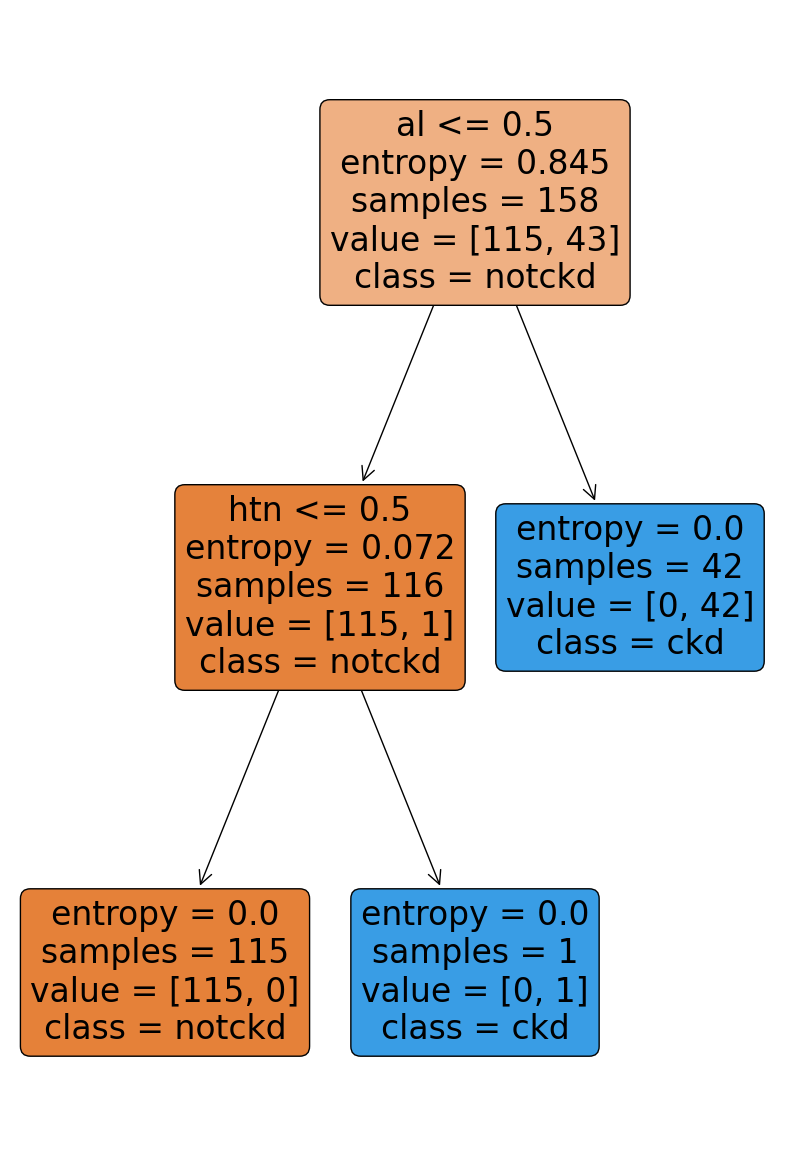

In [81]:
# ------------------ Decision trees -------------------
# Let us use only the complete data (no missing values)
target = Xtrain.classk
inform = Xtrain.drop('classk', axis=1)
clfXtrain = tree.DecisionTreeClassifier(criterion='entropy', random_state=4)
clfXtrain = clfXtrain.fit(inform, target)
test_pred = clfXtrain.predict(x_new.drop('classk', axis=1))
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print('Performance of the decision tree based on the training dataset only:')
print('accuracy =', accuracy_score(x_new.classk, test_pred))
print(confusion_matrix(x_new.classk, test_pred))
plt.figure(figsize=(10, 15))
tree.plot_tree(clfXtrain, feature_names=feat_names[:24],
               class_names=target_names, rounded=True,
               proportion=False, filled=True)
plt.savefig('fig_training.png')

<font size=4>2. Get the **decision tree** and **accuracy** for dataset **xnew**.</font>

<font size=4>3. Add a new dataset $y_{new}$ obtained as follows: find the *median value* of each feature in $X_{train}$, then substitute each missing value of the original dataframe $x$ with the *median value*, so that you have again $400$ rows.</font>

In [82]:
# median, unlike mean, does not suffer the presence of outliers
medians = Xtrain.median()
y_new = xx.fillna(medians, axis=0)
print(f'y_new rows: {y_new.shape[0]}')

y_new rows: 400


<font size=4>4. Add a **random forest classifier** (taken by Scikit Learn) with $100$ and $1000$ trees, use $x_{new}$ and $y_{new}$ as input, and compare *accuracy* and *confusion matrices* with the values provided by the single tree classifiers. Get the **importance** of each feature (available attribute) and plot *importance* versus *feature name*</font>

In [83]:
n_est1 = 100
n_est2 = 1000

clf1 = ensemble.RandomForestClassifier(n_estimators=n_est1, random_state=4)
clf2 = ensemble.RandomForestClassifier(n_estimators=n_est2, random_state=4)

clf1.fit(x_new.drop('classk', axis=1), x_new.classk)
clf2.fit(x_new.drop('classk', axis=1), x_new.classk)

y_new_pred1 = clf1.predict(y_new.drop('classk', axis=1))
y_new_pred2 = clf2.predict(y_new.drop('classk', axis=1))

print(f'Accuracy for clf1: {accuracy_score(y_new.classk, y_new_pred1)}')
print(f'Accuracy for clf2: {accuracy_score(y_new.classk, y_new_pred2)}')

Accuracy for clf1: 0.9775
Accuracy for clf2: 0.98


In [84]:
importances_order1 = np.argsort(clf1.feature_importances_)
importances_order2 = np.argsort(clf2.feature_importances_)
print(f'Importances order for clf1: {importances_order1}')
print(f'Importances order for clf2: {importances_order2}')

Importances order for clf1: [23 20  8  7 21  4  0 22  1 13  6 16 19 10  9 18 12  5 17 11  3 14 15  2]
Importances order for clf2: [20  8  7 23 21 22  0 13  1  4  6 16 10 19  9 12 18  5 11 17  3 15  2 14]


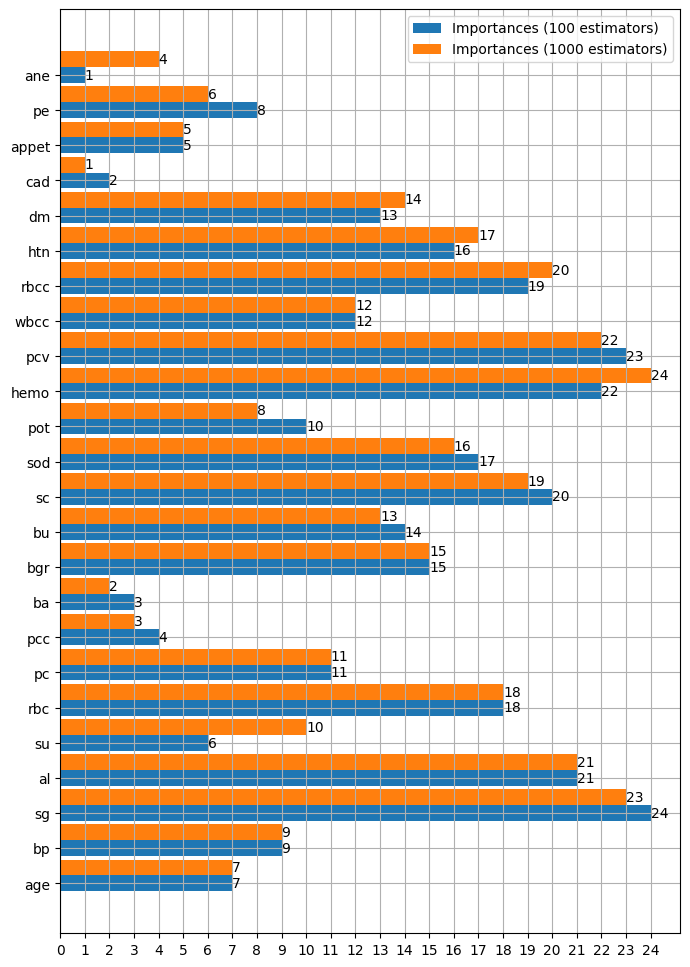

In [85]:
feat_i1 = np.empty(Nf - 1)
feat_i2 = np.empty(Nf - 1)
for i in range(len(feat_i1)):
    feat_i1[i] = np.argwhere(importances_order1 == i).flatten()[0]
    feat_i2[i] = np.argwhere(importances_order2 == i).flatten()[0]
plt.figure(figsize=(8, 12))
h = 0.45
indices = np.arange(Nf - 1)
bars1 = plt.barh(indices, 1 + feat_i1, height=h)
plt.bar_label(bars1)
bars2 = plt.barh(indices + h, 1 + feat_i2, height=h)
plt.bar_label(bars2)
plt.xticks(np.arange(Nf))
plt.yticks(np.arange(Nf - 1), feat_names[:24])
labels = [f'Importances ({n_est1} estimators)', f'Importances ({n_est2} estimators)']
plt.legend(labels)
plt.grid()
plt.show()

<font size=4>5. **Split $y_{new}$ into *training* and *test* subsets (50%), after shuffling**. Remove all the settings about the random seed settings so that each time you run your code you get a different shuffling and different results.</size>

In [86]:
N = xx.shape[0]
Ntrain = int(0.5 * N)
X_sh = y_new.sample(frac=1)
X_tr = X_sh[:Ntrain].drop('classk', axis=1)
X_tr_class = X_sh[:Ntrain].classk
X_te = X_sh[Ntrain:].drop('classk', axis=1)
X_te_class = X_sh[Ntrain:].classk

<font size=4>5.1 Train the **random forest classifier** using the *training* dataset and measure **accuracy** and **confusion matrices** on the *test* dataset only.</font>

In [87]:
clf = ensemble.RandomForestClassifier(n_estimators=100)
clf.fit(X_tr, X_tr_class)
pred = clf.predict(X_te)
accuracy = accuracy_score(X_te_class, pred)
conf_matr = confusion_matrix(X_te_class, pred)

In [88]:
print('Results with Random Forest classifier')
print(f'Accuracy {accuracy}')
print(conf_matr)
print(f'Predicted correctly {conf_matr[0, 0]} healthy and {conf_matr[1, 1]} ckd')
print(f'Predicted wrongly {conf_matr[1, 0]} healthy and {conf_matr[0, 1]} ckd')

Results with Random Forest classifier
Accuracy 1.0
[[ 78   0]
 [  0 122]]
Predicted correctly 78 healthy and 122 ckd
Predicted wrongly 0 healthy and 0 ckd


<font size=4>5.2 Train the **CART tree classifier** using the *training* dataset and measure **accuracy** and **confusion matrices** on the *test* dataset only.</font>

In [89]:
clf = tree.DecisionTreeRegressor()
clf.fit(X_tr, X_tr_class)
pred = clf.predict(X_te)
accuracy = accuracy_score(X_te_class, pred)
conf_matr = confusion_matrix(X_te_class, pred)

In [90]:
print('Results with Random Forest classifier')
print(f'Accuracy {accuracy}')
print(conf_matr)
print(f'Predicted correctly {conf_matr[0, 0]} healthy and {conf_matr[1, 1]} ckd')
print(f'Predicted wrongly {conf_matr[1, 0]} healthy and {conf_matr[0, 1]} ckd')

Results with Random Forest classifier
Accuracy 0.985
[[ 78   0]
 [  3 119]]
Predicted correctly 78 healthy and 119 ckd
Predicted wrongly 3 healthy and 0 ckd
